# Peptide Search

In MS-based proteomics, fragment ion spectra (MS2 spectra) are often
interpreted by comparing them against a theoretical set of spectra
generated from a FASTA database. OpenMS contains a (simple)
implementation of such a "search engine" that compares experimental
spectra against theoretical spectra generated from an enzymatic or
chemical digest of a proteome (e.g. tryptic digest).

## SimpleSearch

In most proteomics applications, a dedicated search engine (such as
Comet, Crux, Mascot, MSGFPlus, MSFragger, Myrimatch, OMSSA, SpectraST or
XTandem; all of which are supported by pyOpenMS) will be used to search
data. Here, we will use the internal `SimpleSearchEngineAlgorithm` from
OpenMS used for teaching purposes. This makes it very easy to search an
(experimental) mzML file against a fasta database of protein sequences:

In [ ]:
from urllib.request import urlretrieve
# from urllib import urlretrieve  # use this code for Python 2.x
from pyopenms import *
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-extra/master"
urlretrieve (gh +"/src/data/SimpleSearchEngine_1.mzML", "searchfile.mzML")
urlretrieve (gh +"/src/data/SimpleSearchEngine_1.fasta", "search.fasta")
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("searchfile.mzML", "search.fasta", protein_ids, peptide_ids) 

This will print search engine output including the number of peptides
and proteins in the database and how many spectra were matched to
peptides and proteins:

``` console
Peptide statistics

  unmatched                : 0 (0 %)
  target/decoy:
    match to target DB only: 3 (100 %)
    match to decoy DB only : 0 (0 %)
    match to both          : 0 (0 %)
```

## PSM inspection

We can now investigate the individual hits as we have done before in the
[Identification
tutorial](datastructures_id.ipynb#PeptideIdentification).

In [ ]:
for peptide_id in peptide_ids:
  # Peptide identification values
  print (35*"=")
  print ("Peptide ID m/z:", peptide_id.getMZ())
  print ("Peptide ID rt:", peptide_id.getRT())
  print ("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
  print ("Peptide scan name:", peptide_id.getMetaValue("scan_index"))
  print ("Peptide ID score type:", peptide_id.getScoreType())
  # PeptideHits
  for hit in peptide_id.getHits():
    print(" - Peptide hit rank:", hit.getRank())
    print(" - Peptide hit charge:", hit.getCharge())
    print(" - Peptide hit sequence:", hit.getSequence())
    mz = hit.getSequence().getMonoWeight(Residue.ResidueType.Full, hit.getCharge()) / hit.getCharge()
    print(" - Peptide hit monoisotopic m/z:", mz) 
    print(" - Peptide ppm error:", abs(mz - peptide_id.getMZ())/mz *10**6 )
    print(" - Peptide hit score:", hit.getScore())

We notice that the second peptide spectrum match (PSM) was found for the
third spectrum in the file for a precursor at 775.38 m/z for the
sequence `RPGADSDIGGFGGLFDLAQAGFR`.

In [ ]:
tsg = TheoreticalSpectrumGenerator()
thspec = MSSpectrum()
p = Param()
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = AASequence.fromString("RPGADSDIGGFGGLFDLAQAGFR")
tsg.getSpectrum(thspec, peptide, 1, 1)
# Iterate over annotated ions and their masses
for ion, peak in zip(thspec.getStringDataArrays()[0], thspec):
    print(ion, peak.getMZ())

e = MSExperiment()
MzMLFile().load("searchfile.mzML", e)
print ("Spectrum native id", e[2].getNativeID() )
mz,i = e[2].get_peaks()
peaks = [(mz,i) for mz,i in zip(mz,i) if i > 1500 and mz > 300]
for peak in peaks:
  print (peak[0], "mz", peak[1], "int")

Comparing the theoretical spectrum and the experimental spectrum for
`RPGADSDIGGFGGLFDLAQAGFR` we can easily see that the most abundant ions
in the spectrum are y8 (877.452 m/z), b10 (926.432), y9 (1024.522 m/z)
and b13 (1187.544 m/z).

## Visualization

When loading the `searchfile.mzML` into the OpenMS visualization
software TOPPView, we can convince ourselves that the observed spectrum
indeed was generated by the peptide `RPGADSDIGGFGGLFDLAQAGFR` by loading
the corresponding theoretical spectrum into the viewer using
"Tools"->"Generate theoretical spectrum":

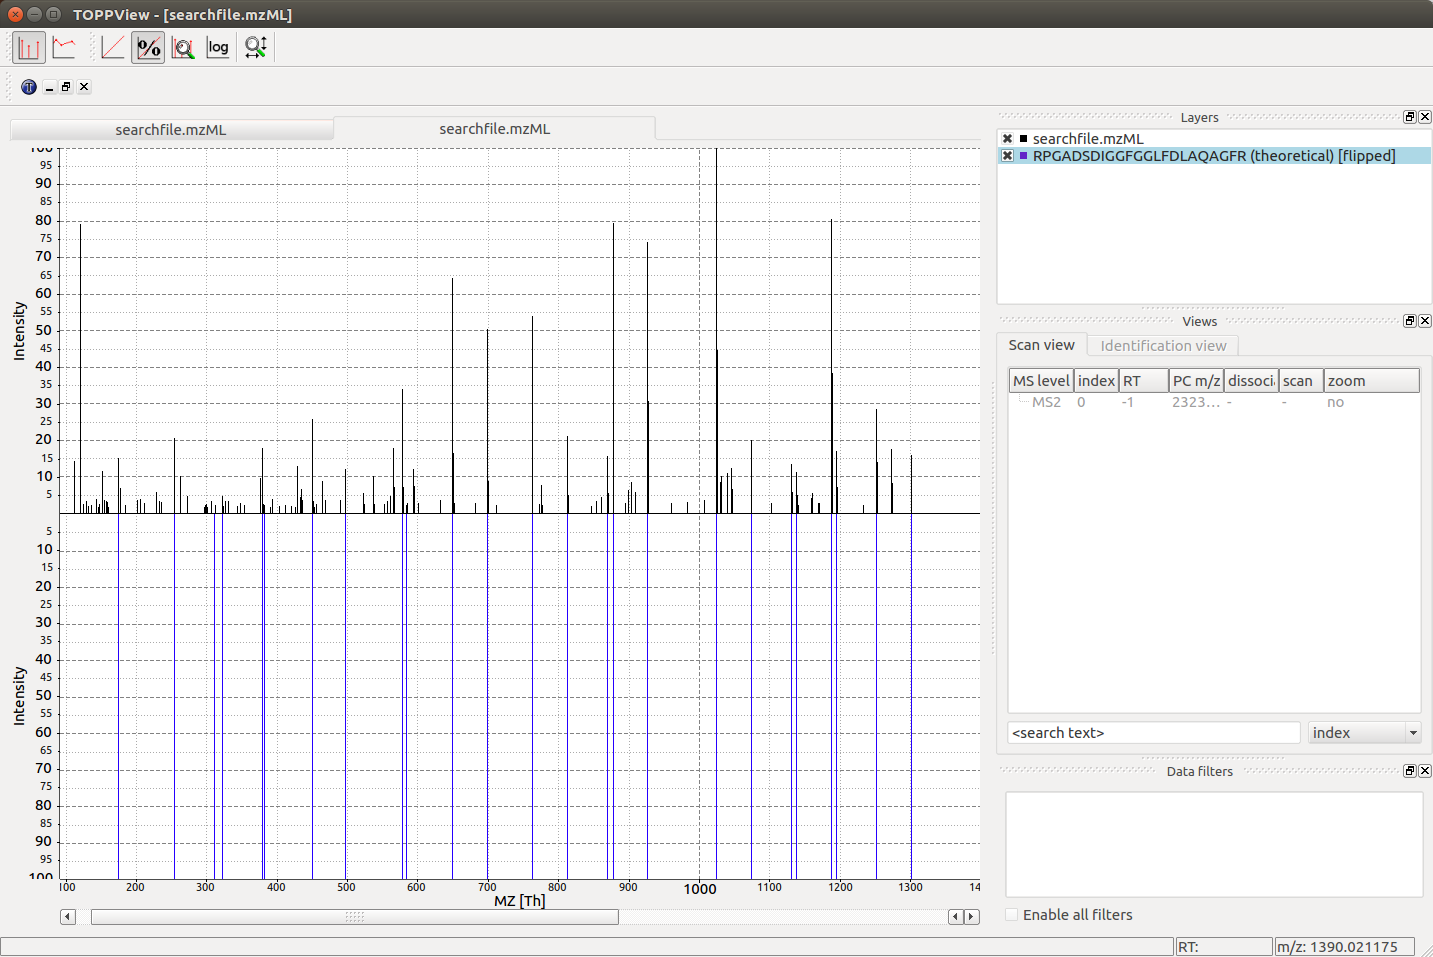

From our output above, we notice that the second peptide spectrum match
(PSM) at 775.38 m/z for sequence `RPGADSDIGGFGGLFDLAQAGFR` was found
with an error tolerance of 2.25 ppm, therefore if we set the precursor
mass tolerance to 4 ppm (+/- 2ppm), we expect that we will not find the
hit at 775.38 m/z any more:

In [ ]:
salgo = SimpleSearchEngineAlgorithm()
p = salgo.getDefaults()
print ( p.items() )
p[b'precursor:mass_tolerance'] = 4.0
salgo.setParameters(p)

protein_ids = []
peptide_ids = []
salgo.search("searchfile.mzML", "search.fasta", protein_ids, peptide_ids) 
print("Found", len(peptide_ids), "peptides")

As we can see, using a smaller precursor mass tolerance leads the
algorithm to find only one hit instead of two. Similarly, if we use the
wrong enzyme for the digestion (e.g. `p[b'enzyme'] = "Formic_acid"`), we
find no results.

## More detailed example

Now include some additional decoy database generation step as well as
subsequent FDR filtering.

In [ ]:
from urllib.request import urlretrieve
# from urllib import urlretrieve  # use this code for Python 2.x
from pyopenms import *
searchfile = "../../src/data/BSA1.mzML"
searchdb = "../../src/data/18Protein_SoCe_Tr_detergents_trace.fasta"

# generate a protein database with additional decoy sequenes
targets = list()
decoys = list()
FASTAFile().load(searchdb, targets) # read FASTA file into a list of FASTAEntrys
decoy_generator = DecoyGenerator()
for entry in targets:
    rev_entry = FASTAEntry(entry) # copy entry
    rev_entry.identifier = "DECOY_" + rev_entry.identifier # mark as decoy
    aas = AASequence().fromString(rev_entry.sequence) # convert string into amino acid sequence
    rev_entry.sequence = decoy_generator.reverseProtein(aas).toString() # reverse
    decoys.append(rev_entry)

target_decoy_database = "search_td.fasta"
FASTAFile().store(target_decoy_database, targets + decoys) # store the database with appended decoy sequences

# Run SimpleSearchAlgorithm, store protein and peptide ids
protein_ids = []
peptide_ids = []

# set some custom search parameters
simplesearch = SimpleSearchEngineAlgorithm()
params = simplesearch.getDefaults()
score_annot = [b'fragment_mz_error_median_ppm', b'precursor_mz_error_ppm']
params.setValue(b'annotate:PSM', score_annot)
params.setValue(b'peptide:max_size', 30)
simplesearch.setParameters(params)

simplesearch.search(searchfile, target_decoy_database, protein_ids, peptide_ids)

# Annotate q-value
FalseDiscoveryRate().apply(peptide_ids)

# Filter by 1% PSM FDR (q-value < 0.01)
idfilter = IDFilter()
idfilter.filterHitsByScore(peptide_ids, 0.01)
idfilter.removeDecoyHits(peptide_ids)

# store PSM-FDR filtered 
IdXMLFile().store("searchfile_results_1perc_FDR.idXML", protein_ids, peptide_ids)

However, usually researchers are interested in the most confidently
identified proteins. This so called *protein inference* problem is a
difficult problem because of often occurring shared/ambiguous peptides.
To be able to calculate a target/decoy-based FDR on the protein level,
we need to assign scores to proteins first (e.g. based on their observed
peptides). This is done by applying one of the available protein
inference algorithms on the peptide and protein IDs.

In [ ]:
protein_ids = []
peptide_ids = []

# Re-run search since we need to keep decoy hits for inference
simplesearch.search(searchfile, target_decoy_database, protein_ids, peptide_ids)

# Run inference
BasicProteinInferenceAlgorithm().run(peptide_ids, protein_ids)

# Annotate q-value on protein level
FalseDiscoveryRate().apply(protein_ids)

# Filter by 1% protein FDR (q-value < 0.01)
idfilter = IDFilter()
idfilter.filterHitsByScore(protein_ids, 0.01)
idfilter.removeDecoyHits(protein_ids)
# Restore valid references into the proteins
remove_peptides_without_reference = True
idfilter.updateProteinReferences(peptide_ids, protein_ids, remove_peptides_without_reference)

# store protein-FDR filtered 
IdXMLFile().store("searchfile_results_1perc_protFDR.idXML", protein_ids, peptide_ids)

[](https://mybinder.org/v2/gh/OpenMS/pyopenms-extra/master+ipynb?urlpath=lab/tree/docs/source/peptide_search.ipynb)